# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [7]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

In [8]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Load ROOT file

In [9]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [12]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  82.46779894828796  seconds


In [13]:
zmumu_unknown = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
)['EventTree']

In [14]:
zmumu_unknown.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [15]:
mybranches_unknown = []
for mykey in zmumu_unknown.keys():
    mybranches_unknown += [mykey.decode("utf-8")]

In [16]:
Events_unknown = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
],
                               "EventTree",
                               branch_list=mybranches_unknown,
                               col_names=mybranches_unknown,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  977568
Events in returned Object:  977568
Loading the data took  68.53048801422119  seconds


### Unpack data

In [17]:
weightsMC_0 = Events_0.events['weight']
# standardize
weightsMC_0 = weightsMC_0/np.mean(weightsMC_0)

weightsMC_unknown = Events_unknown.events['weight']
# standardize
weightsMC_unknown = weightsMC_unknown/np.mean(weightsMC_unknown)

In [18]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

mypass_unknown = (Events_unknown.events['m_ll'] > 0) & (Events_unknown.events['m_ll'] < 200) & (
    Events_unknown.events['truth_m_ll'] > 0) & (Events_unknown.events['truth_m_ll'] < 200)

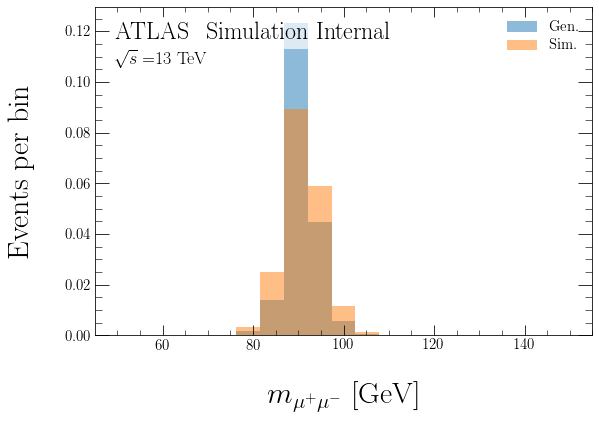

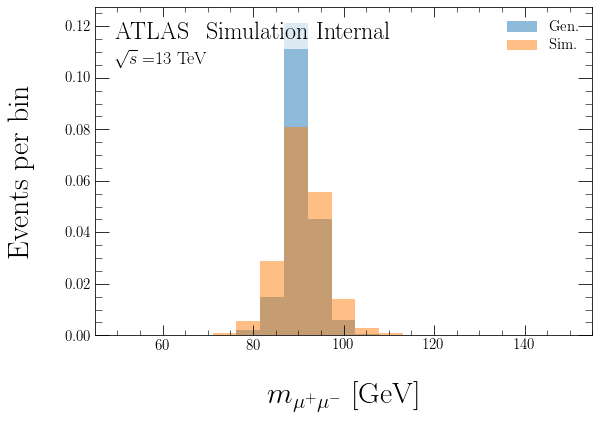

In [19]:
plt.figure()
hG, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

plt.figure()
hG, _, _ = plt.hist(Events_unknown.events['truth_m_ll'][mypass_unknown],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_unknown.events['m_ll'][mypass_unknown],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [20]:
mytracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_0_Gen = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [21]:
mytracks_0 = Events_0.events['pT_Tracks'][mypass_0]
ntrack_0_Sim = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [22]:
mytracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
ntrack_unknown_Gen = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

In [23]:
mytracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]
ntrack_unknown_Sim = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

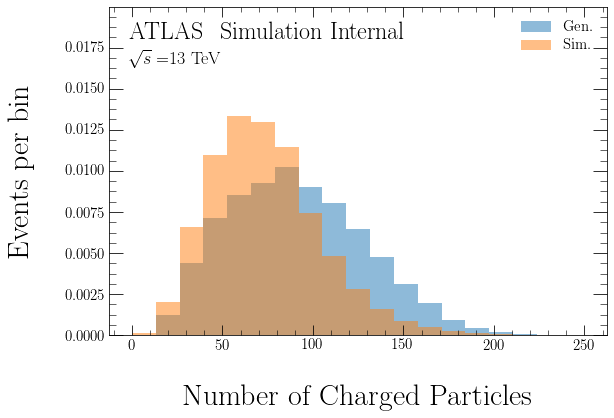

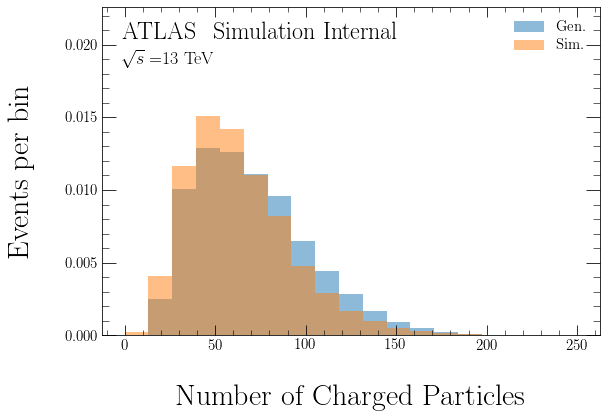

In [24]:
hG, _, _ = plt.hist(ntrack_0_Gen,
#                     weights=weightsMC_0[mypass_0],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_0_Sim,
#                     weights=weightsMC_0[mypass_0],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

hG, _, _ = plt.hist(ntrack_unknown_Gen,
#                     weights=weightsMC_unknown[mypass_unknown],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_unknown_Sim,
#                     weights=weightsMC_unknown[mypass_unknown],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [24]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

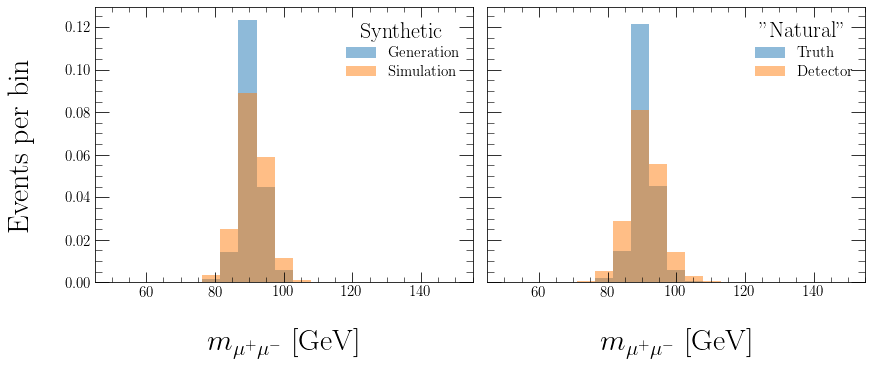

In [26]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, 
                       label='Generation', 
                       **plot_style_2)
hS0, _, _ = ax[0].hist(m_ll_0_S, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, label='Simulation', 
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, 
#                        weights=weightsMC_unknown[mypass_unknown], 
                       bins=bins,
                       label='Truth', 
                       **plot_style_2)
hS1, _, _ = ax[1].hist(m_ll_unknown_S, 
#                        weights=weightsMC_unknown[mypass_unknown], 
                       bins=bins, 
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [27]:
nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)
nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

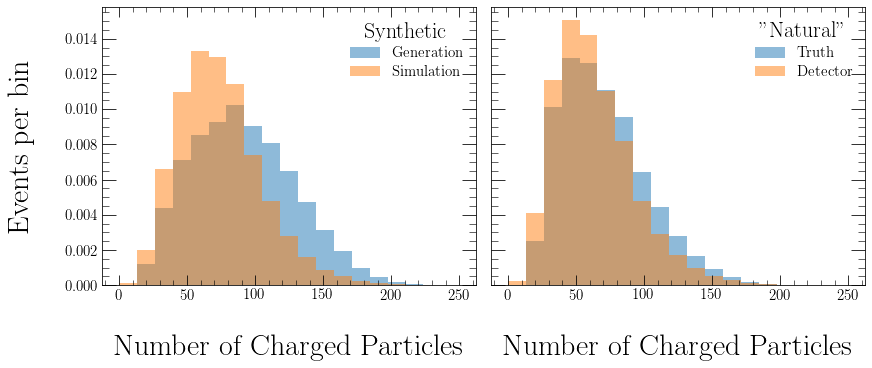

In [28]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Generation',
                       **plot_style_2)
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Simulation',
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Truth',
                       **plot_style_2)
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [29]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level observable as Numpy array
                    
        theta_0_S: synthetic simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
                            
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            theta_0_G,
            theta_0_S,
            theta_unknown_S,
            weightsMC_0=None,
            weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$

In [30]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=m_ll_0_G / 100.,
                     theta_0_S=m_ll_0_S / 100.,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=m_ll_unknown_S / 100.)#,
#                      weightsMC_unknown=weightsMC_unknown[mypass_unknown])





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1143892 samples, validate on 381298 samples
Epoch 1/200





1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6774 - acc: 0.5877 - val_loss: 0.6762 - val_acc: 0.5918
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6760 - acc: 0.5922 - val_loss: 0.6762 - val_acc: 0.5918
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6760 - acc: 0.5922 - val_loss: 0.6762 - val_acc: 0.5918
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6760 - acc: 0.5922 - val_loss: 0.6762 - val_acc: 0.5918
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6760 - acc: 0.5922 - val_loss: 0.6762 - val_acc: 0.5918
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6760 - acc: 0.5922 - val_lo

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6720 - val_acc: 0.5918
Epoch 36/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6712 - acc: 0.5922 - val_loss: 0.6714 - val_acc: 0.5918
Epoch 37/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6718 - val_acc: 0.5918
Epoch 38/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6715 - val_acc: 0.5918
Epoch 39/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6715 - val_acc: 0.5918
Epoch 40/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6715 - val_acc: 0.5918
Epoch 41/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6714 - val_acc: 0.5918
Restoring model wei

Epoch 39/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8218 - acc: 0.4912 - val_loss: 0.8221 - val_acc: 0.4918
Epoch 40/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8219 - acc: 0.4930 - val_loss: 0.8221 - val_acc: 0.4905
Epoch 41/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8218 - acc: 0.4923 - val_loss: 0.8221 - val_acc: 0.4916
Epoch 42/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8218 - acc: 0.4919 - val_loss: 0.8221 - val_acc: 0.4914
Epoch 43/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8219 - acc: 0.4920 - val_loss: 0.8221 - val_acc: 0.4832
Epoch 44/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8218 - acc: 0.4928 - val_loss: 0.8221 - val_acc: 0.4865
Epoch 45/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8218 - acc: 0.4916 - val_loss: 0.8221 - val_acc: 0.5016
Epoch 

Epoch 15/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8151 - acc: 0.4968 - val_loss: 0.8144 - val_acc: 0.4878
Epoch 16/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8151 - acc: 0.4971 - val_loss: 0.8145 - val_acc: 0.5014
Epoch 17/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8151 - acc: 0.4958 - val_loss: 0.8146 - val_acc: 0.4870
Epoch 18/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8152 - acc: 0.4968 - val_loss: 0.8144 - val_acc: 0.4879
Epoch 19/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8151 - acc: 0.4955 - val_loss: 0.8144 - val_acc: 0.4871
Epoch 20/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8152 - acc: 0.4974 - val_loss: 0.8146 - val_acc: 0.4574
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoc

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8194 - acc: 0.4691 - val_loss: 0.8193 - val_acc: 0.4750
Epoch 27/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8194 - acc: 0.4705 - val_loss: 0.8193 - val_acc: 0.4755
Epoch 28/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8194 - acc: 0.4662 - val_loss: 0.8194 - val_acc: 0.4908
Epoch 29/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8194 - acc: 0.4684 - val_loss: 0.8194 - val_acc: 0.4558
Epoch 30/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8194 - acc: 0.4679 - val_loss: 0.8195 - val_acc: 0.4516
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8225 - acc: 0.5006 - val_loss: 0.8205 - val_acc: 0.4980
Epoch 2/200
933165/9

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4676 - val_loss: 0.8207 - val_acc: 0.4846
Epoch 29/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4660 - val_loss: 0.8208 - val_acc: 0.4799
Epoch 30/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4657 - val_loss: 0.8207 - val_acc: 0.4594
Epoch 31/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4667 - val_loss: 0.8207 - val_acc: 0.4327
Epoch 32/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4650 - val_loss: 0.8207 - val_acc: 0.4789
Epoch 33/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8204 - acc: 0.4664 - val_loss: 0.8207 - val_acc: 0.4827
Epoch 34/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8205 - acc: 0.4668 - val_loss: 0.8207 - val_acc: 0.4751
Epoch 35/200
114389

933165/933165 [==============================] - 2s 2us/step - loss: 0.8214 - acc: 0.4999 - val_loss: 0.8210 - val_acc: 0.5003
Epoch 18/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8214 - acc: 0.4999 - val_loss: 0.8210 - val_acc: 0.5003
Epoch 19/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8214 - acc: 0.4999 - val_loss: 0.8212 - val_acc: 0.5003
Epoch 20/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8214 - acc: 0.4999 - val_loss: 0.8209 - val_acc: 0.5003
Epoch 21/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8214 - acc: 0.4999 - val_loss: 0.8211 - val_acc: 0.5003
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping

ITERATION: 9

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.8233 - acc: 0.4915 - val_loss: 0.8201 - val_acc: 0.4676
Epoch 2/200
1

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5221 - val_loss: 0.8131 - val_acc: 0.5331
Epoch 19/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5207 - val_loss: 0.8131 - val_acc: 0.5162
Epoch 20/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5205 - val_loss: 0.8129 - val_acc: 0.5425
Epoch 21/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5240 - val_loss: 0.8131 - val_acc: 0.5584
Epoch 22/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5261 - val_loss: 0.8130 - val_acc: 0.5063
Epoch 23/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5200 - val_loss: 0.8130 - val_acc: 0.5471
Epoch 24/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8128 - acc: 0.5228 - val_loss: 0.8129 - val_acc: 0.4833
Epoch 25/200
114389

ITERATION 1:


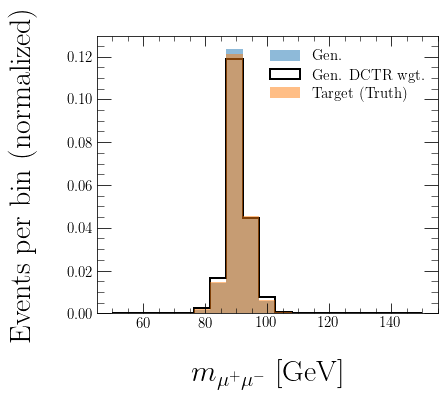

ITERATION 2:


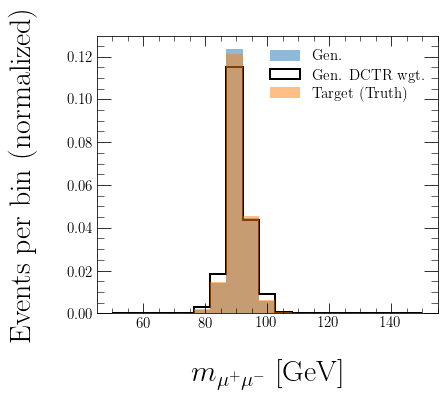

ITERATION 3:


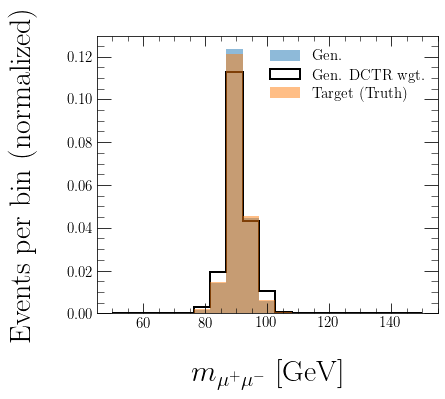

ITERATION 4:


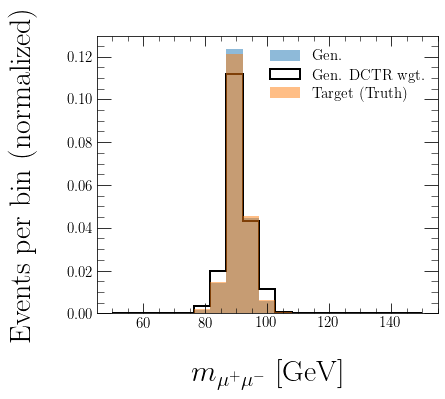

ITERATION 5:


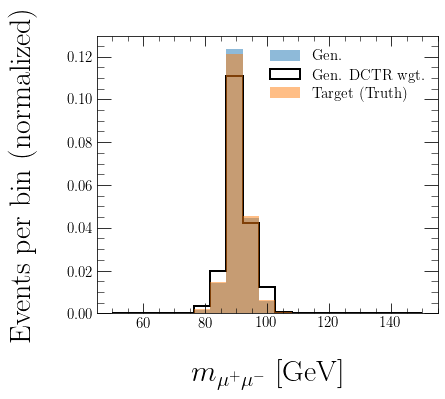

ITERATION 6:


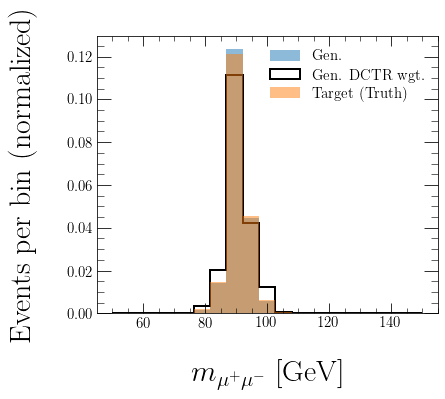

ITERATION 7:


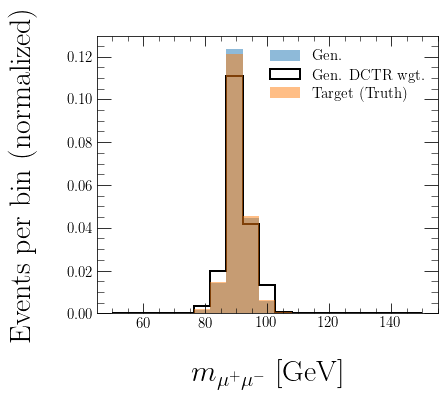

ITERATION 8:


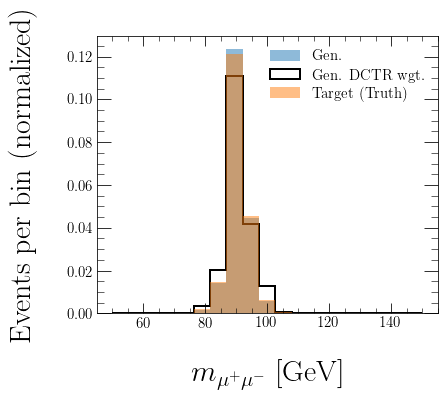

ITERATION 9:


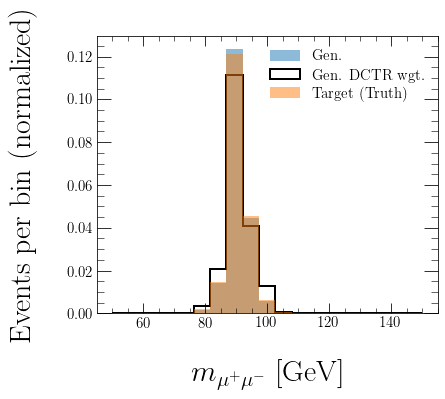

ITERATION 10:


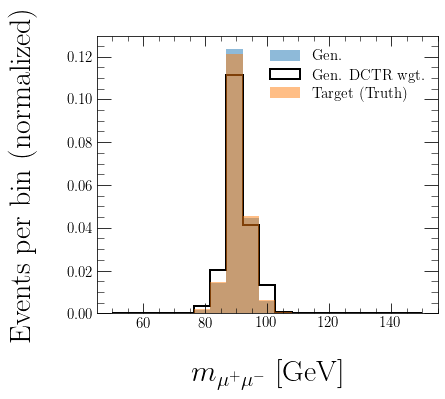

In [31]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(m_ll_0_G,
#                      weights=weightsMC_0[mypass_0],
                     bins=bins,
                     label=r'Gen.',
                     **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(m_ll_unknown_G,
#                      weights=weightsMC_unknown[mypass_unknown],
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [32]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=nTracks_0_G / 100.,
                     theta_0_S=nTracks_0_S / 100.,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=nTracks_unknown_S / 100.)#,
#                      weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 4s 4us/step - loss: 0.6681 - acc: 0.5972 - val_loss: 0.6601 - val_acc: 0.6003
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6597 - acc: 0.6008 - val_loss: 0.6599 - val_acc: 0.6024
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6595 - acc: 0.6011 - val_loss: 0.6595 - val_acc: 0.6016
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6594 - acc: 0.6020 - val_loss: 0.6593 - val_acc: 0.6023
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6594 - acc: 0.6019 - val_loss: 0.6593 - val_acc: 0.6024
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6594 - acc: 0.6019 - val_loss: 0.6593 - val_acc: 0.6024
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5739 - val_loss: 0.8155 - val_acc: 0.5775
Epoch 20/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5738 - val_loss: 0.8155 - val_acc: 0.5725
Epoch 21/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5741 - val_loss: 0.8154 - val_acc: 0.5749
Epoch 22/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5746 - val_loss: 0.8155 - val_acc: 0.5601
Epoch 23/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5746 - val_loss: 0.8155 - val_acc: 0.5831
Epoch 24/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5747 - val_loss: 0.8154 - val_acc: 0.5808
Epoch 25/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8145 - acc: 0.5742 - val_loss: 0.8155 - val_acc: 0.5855
Epoch 26/200
114389

933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.5002 - val_loss: 0.7966 - val_acc: 0.5000
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.4998 - val_loss: 0.7965 - val_acc: 0.4996
Epoch 5/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.5001 - val_loss: 0.7965 - val_acc: 0.4994
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.4999 - val_loss: 0.7963 - val_acc: 0.4998
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.5000 - val_loss: 0.7964 - val_acc: 0.4999
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.5001 - val_loss: 0.7964 - val_acc: 0.4999
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7957 - acc: 0.5002 - val_loss: 0.7964 - val_acc: 0.4999
Epoch 10/200
933165/933165 [===========

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8180 - acc: 0.5749 - val_loss: 0.8183 - val_acc: 0.5941
Epoch 18/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8180 - acc: 0.5625 - val_loss: 0.8183 - val_acc: 0.5828
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 5s 5us/step - loss: 0.7973 - acc: 0.5001 - val_loss: 0.7900 - val_acc: 0.4992
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7894 - acc: 0.5004 - val_loss: 0.7899 - val_acc: 0.4992
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7895 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4991
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7895 - acc: 0.5004 - val_loss: 0.7899 - val_acc: 0.4990
Epoch 5/200
933165/933165 [==

933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5003 - val_loss: 0.7899 - val_acc: 0.4986
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5005 - val_loss: 0.7898 - val_acc: 0.4991
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5002 - val_loss: 0.7899 - val_acc: 0.4986
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5002 - val_loss: 0.7899 - val_acc: 0.4986
Epoch 10/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5002 - val_loss: 0.7897 - val_acc: 0.4991
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7889 - acc: 0.5002 - val_loss: 0.7897 - val_acc: 0.4991
Epoch 12/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7890 - acc: 0.5002 - val_loss: 0.7900 - val_acc: 0.4986
Restoring model weights from the end

ITERATION 1:


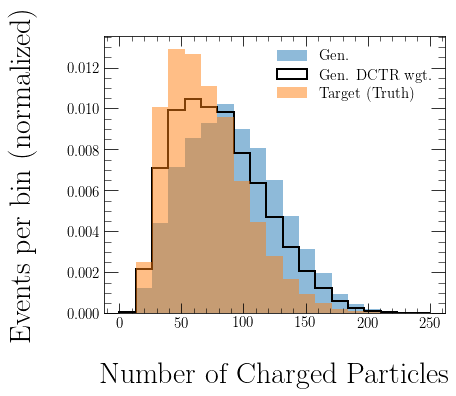

ITERATION 2:


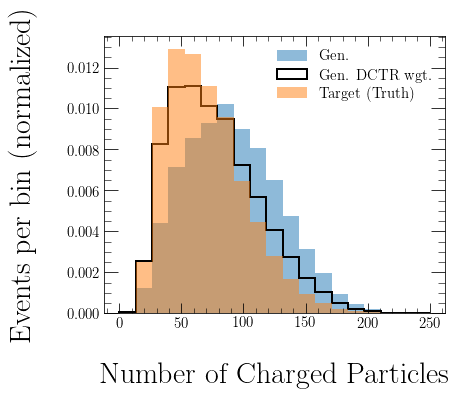

ITERATION 3:


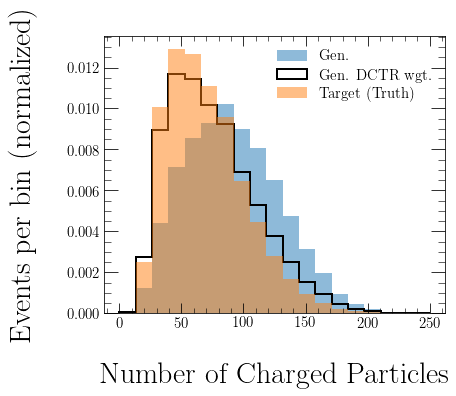

ITERATION 4:


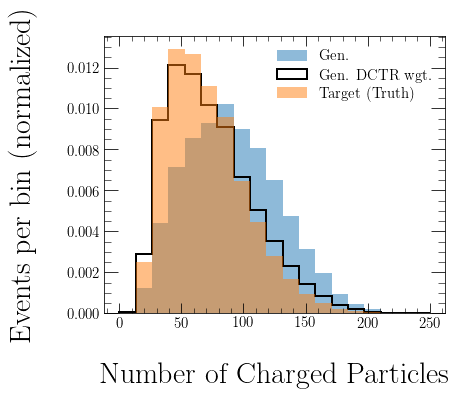

ITERATION 5:


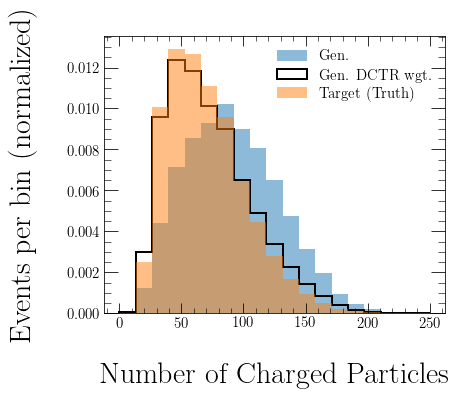

ITERATION 6:


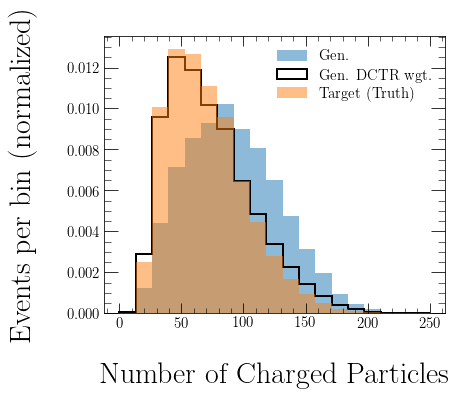

ITERATION 7:


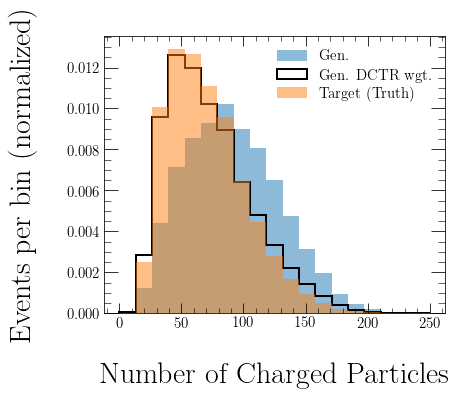

ITERATION 8:


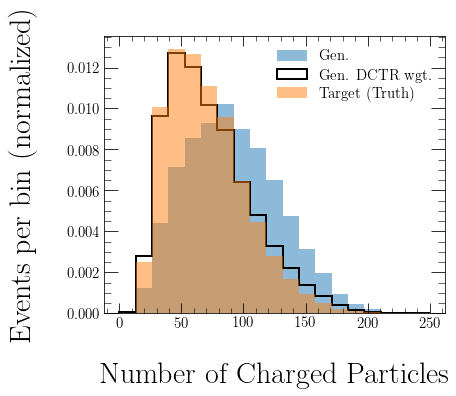

ITERATION 9:


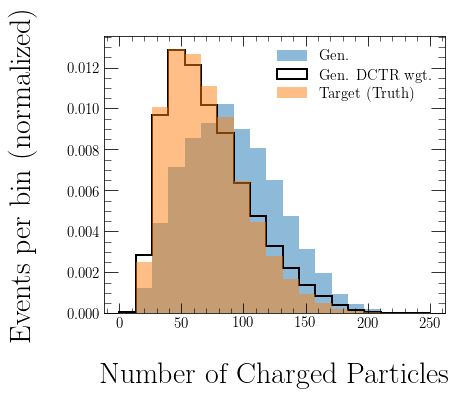

ITERATION 10:


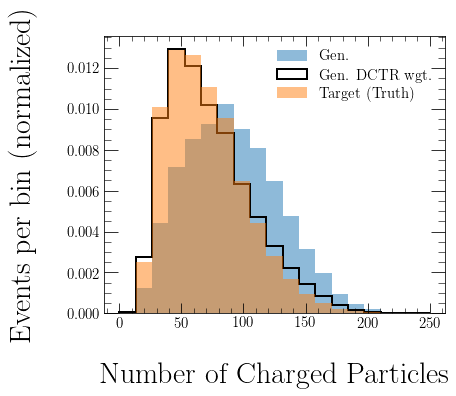

In [33]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(nTracks_0_G, 
#                      weights=weightsMC_0[mypass_0], 
                     bins=bins, label=r'Gen.', 
                     **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(nTracks_unknown_G,
#                      weights=weightsMC_unknown[mypass_unknown],
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [34]:
K.clear_session()

### Setup datasets

In [35]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)

nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

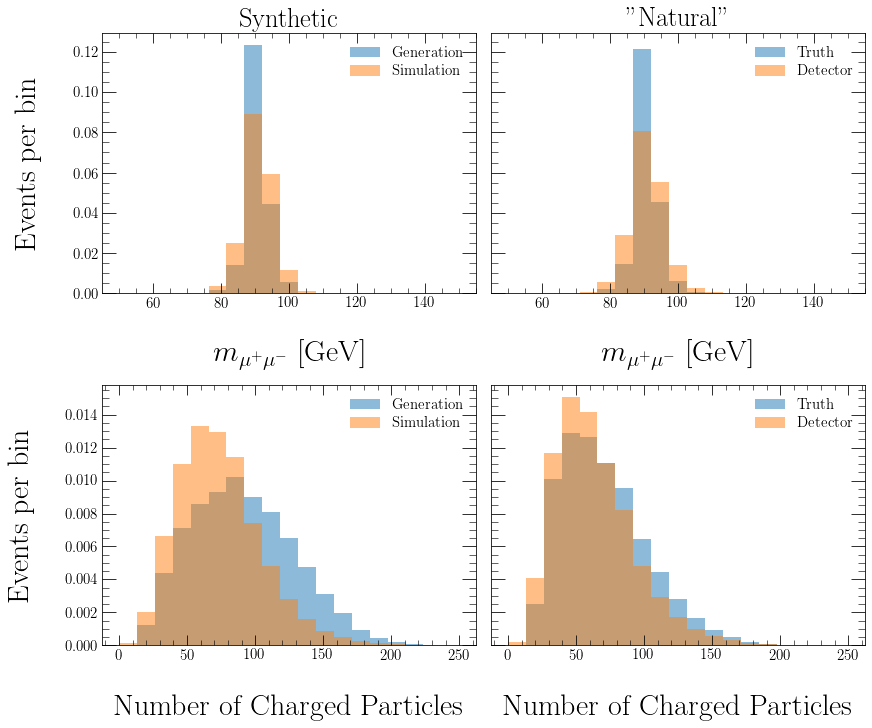

In [36]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [37]:
# Input multiple observables as tuple or list (i.e. theta_0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta_0_G: tuple or list of synthetic 
                    generation-level observables as Numpy arrays
                    
        theta_0_S: tuple or list of synthetic 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def multifold(num_observables,
              iterations,
              theta_0_G,
              theta_0_S,
              theta_unknown_S,
              weightsMC_0=None,
              weightsMC_unknown=None):

    theta_0_G = np.stack(theta_0_G, axis=1)
    theta_0_S = np.stack(theta_0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta_0_S))
    weights_push = np.ones(len(theta_0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta_0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [38]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=(m_ll_0_G / 100., nTracks_0_G / 100.),
                       theta_0_S=(m_ll_0_S / 100., nTracks_0_S / 100.),
#                        weightsMC_0=weightsMC_0[mypass_0],
                       theta_unknown_S=(m_ll_unknown_S / 100.,
                                        nTracks_unknown_S / 100.))#,
#                        weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6671 - acc: 0.5893 - val_loss: 0.6597 - val_acc: 0.6023
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6593 - acc: 0.6017 - val_loss: 0.6596 - val_acc: 0.6018
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6593 - acc: 0.6017 - val_loss: 0.6596 - val_acc: 0.6022
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6593 - acc: 0.6019 - val_loss: 0.6595 - val_acc: 0.6024
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6592 - acc: 0.6018 - val_loss: 0.6595 - val_acc: 0.6027
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6591 - acc: 0.6021 - val_loss: 0.6596 - val_acc: 0.6028
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l


ITERATION: 2

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 3s 3us/step - loss: 0.8399 - acc: 0.5481 - val_loss: 0.8360 - val_acc: 0.5525
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8371 - acc: 0.5524 - val_loss: 0.8361 - val_acc: 0.5535
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8370 - acc: 0.5520 - val_loss: 0.8361 - val_acc: 0.5451
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8370 - acc: 0.5518 - val_loss: 0.8360 - val_acc: 0.5538
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8370 - acc: 0.5532 - val_loss: 0.8359 - val_acc: 0.5512
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8371 - acc: 0.5525 - val_loss: 0.8360 - val_acc: 0.5448
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l

933165/933165 [==============================] - 2s 2us/step - loss: 0.7836 - acc: 0.5005 - val_loss: 0.7840 - val_acc: 0.4988
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7836 - acc: 0.5003 - val_loss: 0.7838 - val_acc: 0.4990
Epoch 5/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7836 - acc: 0.5003 - val_loss: 0.7838 - val_acc: 0.4990
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7836 - acc: 0.5004 - val_loss: 0.7840 - val_acc: 0.4985
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7837 - acc: 0.5004 - val_loss: 0.7849 - val_acc: 0.4992
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7837 - acc: 0.5004 - val_loss: 0.7840 - val_acc: 0.4989
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7836 - acc: 0.5003 - val_loss: 0.7840 - val_acc: 0.4989
Epoch 10/200
933165/933165 [===========

933165/933165 [==============================] - 2s 2us/step - loss: 0.7798 - acc: 0.4999 - val_loss: 0.7794 - val_acc: 0.5001
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7797 - acc: 0.4998 - val_loss: 0.7796 - val_acc: 0.5003
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7798 - acc: 0.5000 - val_loss: 0.7794 - val_acc: 0.5002
Epoch 10/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7798 - acc: 0.4999 - val_loss: 0.7800 - val_acc: 0.5002
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7800 - acc: 0.5000 - val_loss: 0.7796 - val_acc: 0.5005
Epoch 12/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7799 - acc: 0.5000 - val_loss: 0.7797 - val_acc: 0.5004
Epoch 13/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7798 - acc: 0.4998 - val_loss: 0.7795 - val_acc: 0.5005
Epoch 14/200
933165/933165 [=======

933165/933165 [==============================] - 2s 2us/step - loss: 0.7773 - acc: 0.5001 - val_loss: 0.7771 - val_acc: 0.4993
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7774 - acc: 0.5001 - val_loss: 0.7776 - val_acc: 0.4995
Epoch 12/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7773 - acc: 0.5004 - val_loss: 0.7771 - val_acc: 0.4991
Epoch 13/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7772 - acc: 0.5003 - val_loss: 0.7771 - val_acc: 0.4991
Epoch 14/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7772 - acc: 0.5000 - val_loss: 0.7774 - val_acc: 0.4993
Epoch 15/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7772 - acc: 0.5002 - val_loss: 0.7774 - val_acc: 0.4992
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 7

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
11

Epoch 8/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8232 - acc: 0.4704 - val_loss: 0.8239 - val_acc: 0.4618
Epoch 9/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8232 - acc: 0.4700 - val_loss: 0.8239 - val_acc: 0.4852
Epoch 10/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8233 - acc: 0.4702 - val_loss: 0.8239 - val_acc: 0.4710
Epoch 11/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8233 - acc: 0.4644 - val_loss: 0.8238 - val_acc: 0.4764
Epoch 12/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8233 - acc: 0.4723 - val_loss: 0.8239 - val_acc: 0.4459
Epoch 13/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8232 - acc: 0.4678 - val_loss: 0.8240 - val_acc: 0.4729
Epoch 14/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8232 - acc: 0.4647 - val_loss: 0.8239 - val_acc: 0.4890
Epoch 15

Epoch 24/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8156 - acc: 0.4973 - val_loss: 0.8164 - val_acc: 0.5072
Epoch 25/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8156 - acc: 0.4882 - val_loss: 0.8164 - val_acc: 0.5634
Epoch 26/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8156 - acc: 0.4949 - val_loss: 0.8163 - val_acc: 0.5275
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 4s 4us/step - loss: 0.7885 - acc: 0.4994 - val_loss: 0.7792 - val_acc: 0.5015
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7797 - acc: 0.4994 - val_loss: 0.7791 - val_acc: 0.5015
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.7797 - acc: 0.4996 - val_loss: 0.7794 - val_acc: 0.5014
Epoch 4/200
9

ITERATION: 1


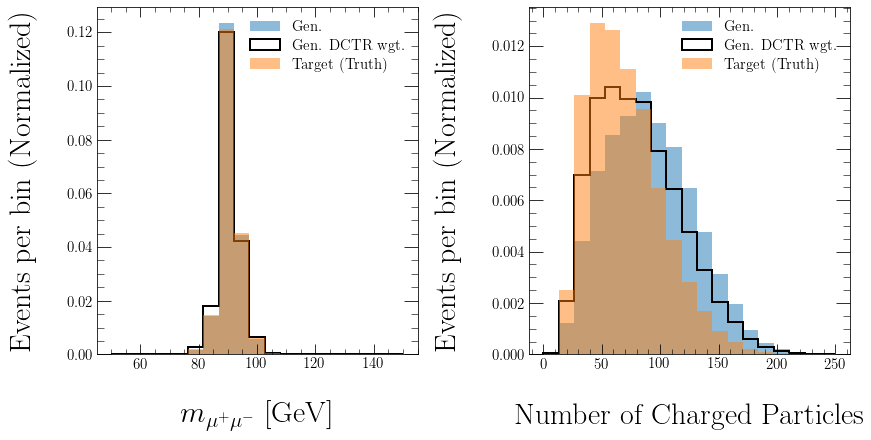

ITERATION: 2


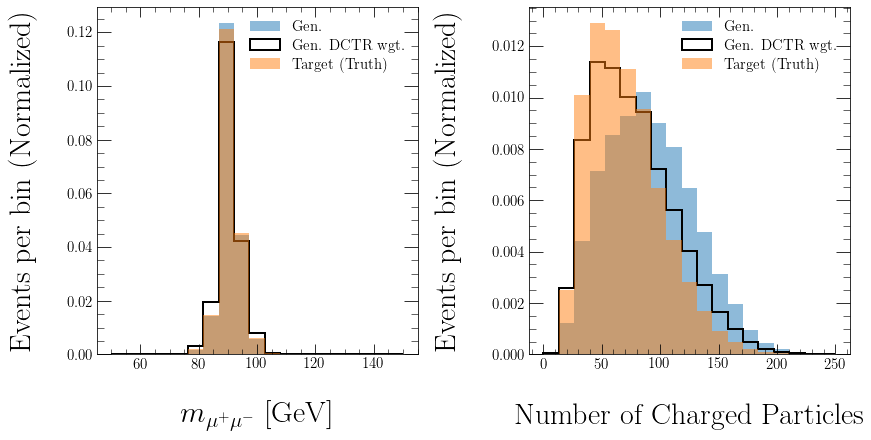

ITERATION: 3


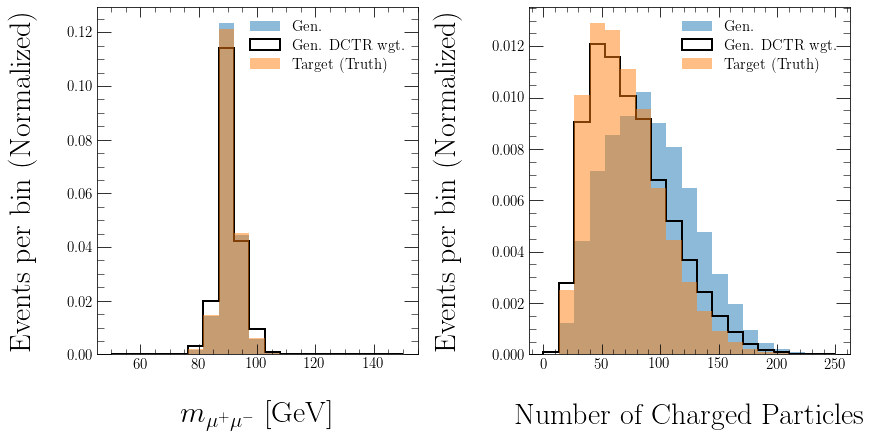

ITERATION: 4


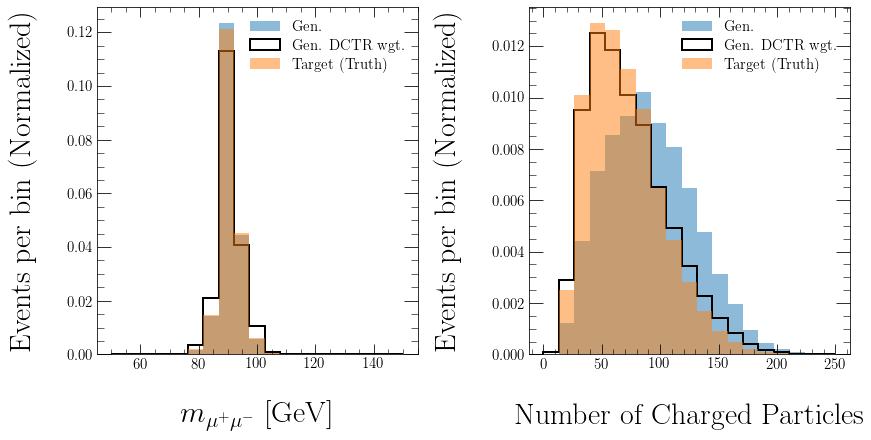

ITERATION: 5


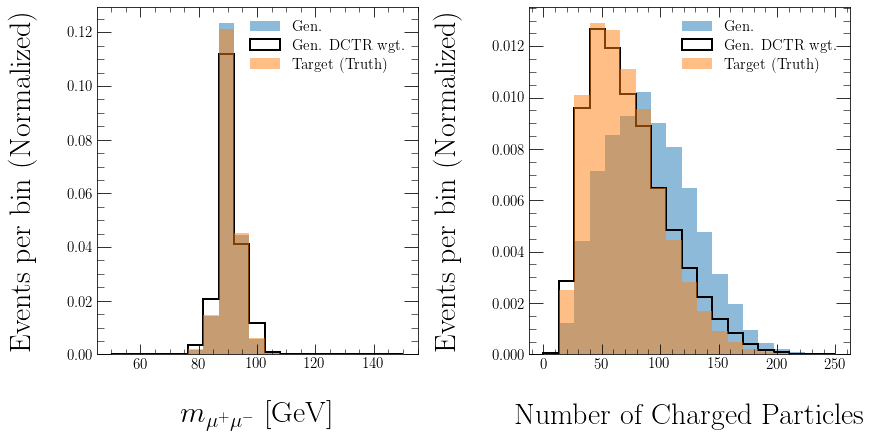

ITERATION: 6


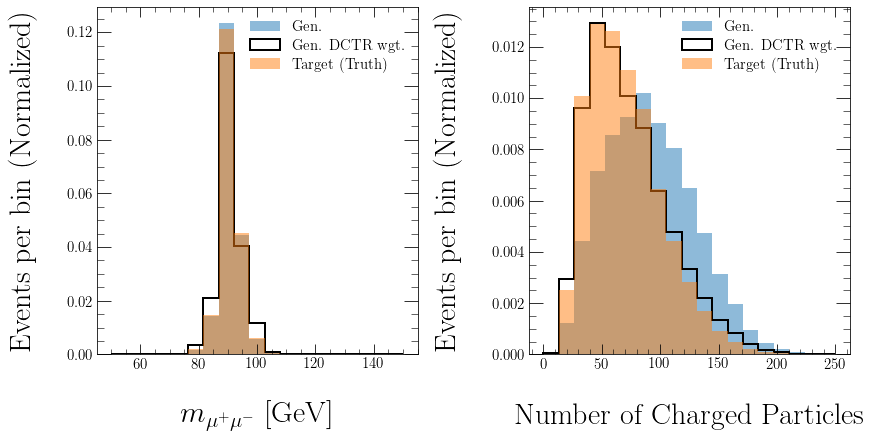

ITERATION: 7


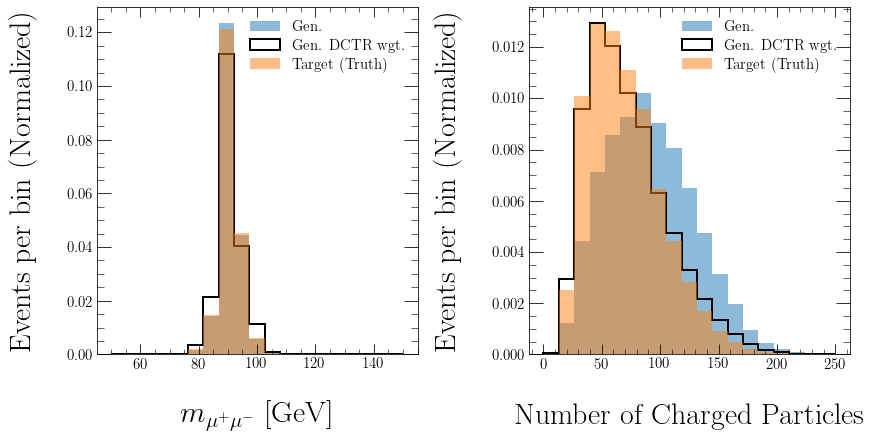

ITERATION: 8


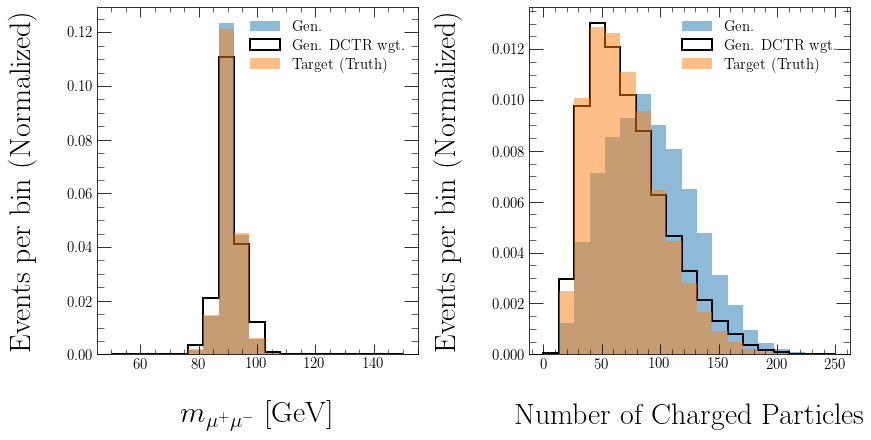

ITERATION: 9


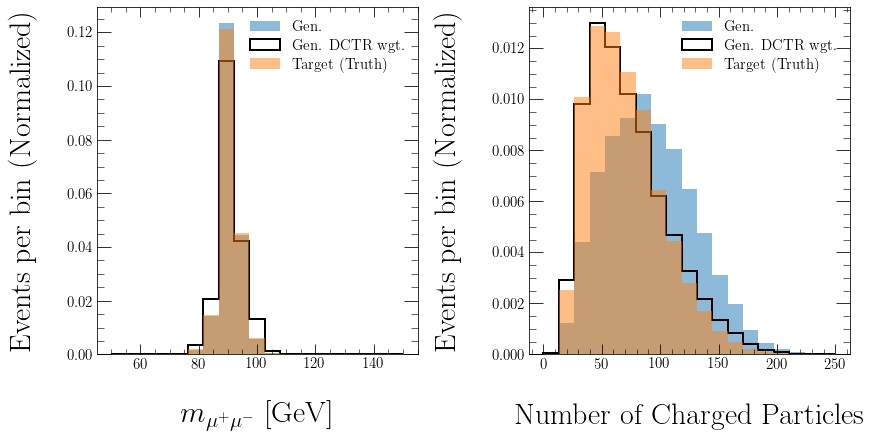

ITERATION: 10


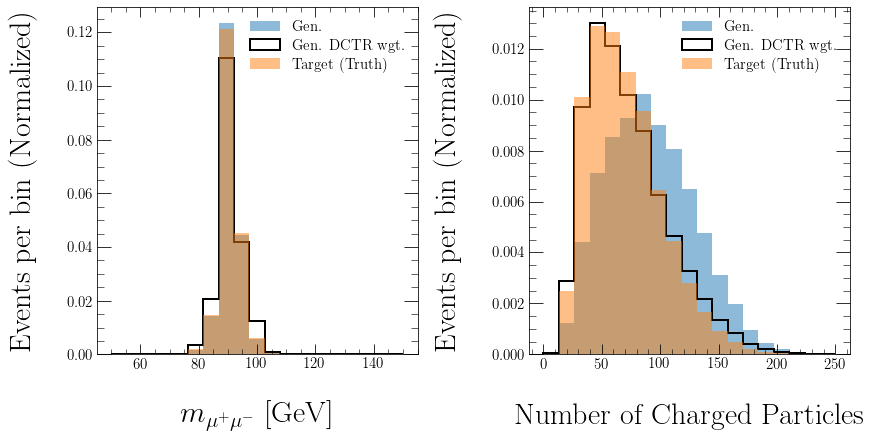

In [39]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_G, 
#                weights=weightsMC_0[mypass_0],
               bins=bins, 
               label=r'Gen.', 
               **plot_style_2)
    ax[0].hist(m_ll_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(m_ll_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G, 
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Gen.',
               **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## OmniFold

Unfold the full phase space of the tracks.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [25]:
K.clear_session()

### Setup datasets

#### Get particle charge from particle ID

Since we can only observe charge at detector-level, we must convert the PID information at particle-level to charge information.

In [26]:
# Load different particles in dataset

truth_pdgId_Tracks_0 = Events_0.events['truth_pdgId_Tracks'][mypass_0]

truth_pdgId_Tracks_unknown = Events_unknown.events['truth_pdgId_Tracks'][mypass_unknown]

In [27]:
# See what kind of particles are in event

PIDs = []

for event in truth_pdgId_Tracks_0:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]
            
for event in truth_pdgId_Tracks_unknown:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]

In [28]:
PIDs

[-13,
 -211,
 321,
 211,
 -321,
 13,
 -2212,
 2212,
 -3312,
 3112,
 -11,
 11,
 -3222,
 3334,
 -3112,
 3312,
 3222,
 -3334]

In [29]:
# Look up particles and their charge from
# https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf

PID_to_charge = {
    11: -1,  # e^-
    13: -1,  # mu^-
    211: 1,  # pi^+
    321: 1,  # K^+
    2212: 1,  # p
    3112: -1,  # Sigma^-
    3312: -1,  # Xi^-
    3222: +1,  # Sigma^+
    3334: -1   # Omega^-
}  

In [30]:
def get_charge(pdgID):
    charges = awkward.array.jagged.JaggedArray.copy(pdgID)
    for i in range(len(charges)):
        for j in range(len(charges[i])):
            PID = charges[i][j]
            # anti-particles have a negative sign
            sign = PID / abs(PID)
            try:
                charge = sign * PID_to_charge[abs(PID)]
            except KeyError:
                raise ValueError(
                    "Unknown PID encountered: {}. Please add PID and corresponding charge to 'PID_to_charge.'"
                    .format(PID))
                return
            charges[i][j] = charge
    return charges

#### Load and process tracks

Unfolding the full phase space involves the use of EnergyFlow PFNs, which take zero-padded arrays as input.

In [31]:
truth_pT_Tracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
pT_Tracks_0 = Events_0.events['pT_Tracks'][mypass_0]

truth_eta_Tracks_0 = Events_0.events['truth_eta_Tracks'][mypass_0]
eta_Tracks_0 = Events_0.events['eta_Tracks'][mypass_0]

truth_phi_Tracks_0 = Events_0.events['truth_phi_Tracks'][mypass_0]
phi_Tracks_0 = Events_0.events['phi_Tracks'][mypass_0]

truth_charge_Tracks_0 = get_charge(truth_pdgId_Tracks_0)
charge_Tracks_0 = Events_0.events['charge_Tracks'][mypass_0]


truth_pT_Tracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
pT_Tracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]

truth_eta_Tracks_unknown = Events_unknown.events['truth_eta_Tracks'][mypass_unknown]
eta_Tracks_unknown = Events_unknown.events['eta_Tracks'][mypass_unknown]

truth_phi_Tracks_unknown = Events_unknown.events['truth_phi_Tracks'][mypass_unknown]
phi_Tracks_unknown = Events_unknown.events['phi_Tracks'][mypass_unknown]

truth_charge_Tracks_unknown = get_charge(truth_pdgId_Tracks_unknown)
charge_Tracks_unknown = Events_unknown.events['charge_Tracks'][mypass_unknown]

In [32]:
sum_pT_Tracks_0_G = [
    np.sum(truth_pT_Tracks_0[i]) for i in range(len(truth_pT_Tracks_0))
]
sum_pT_Tracks_0_S = [np.sum(pT_Tracks_0[i]) for i in range(len(pT_Tracks_0))]


sum_pT_Tracks_unknown_G = [
    np.sum(truth_pT_Tracks_unknown[i]) for i in range(len(truth_pT_Tracks_unknown))
]
sum_pT_Tracks_unknown_S = [np.sum(pT_Tracks_unknown[i]) for i in range(len(pT_Tracks_unknown))]

In [33]:
def get_max_dim(array):
    max_dim = max([len(array[i]) for i in range(len(array))])

    return max_dim

In [34]:
# normalize or standardize pT and center (y, phi)
def normalize_event(x, normalize=True):
    if normalize:
        yphi_avg = np.average(x[:, 1:3], weights=x[:, 0], axis=0)
        x[:, 1:3] -= yphi_avg
        x[:, 0] /= x[:, 0].sum()
    else:  # standardize
        x[:, 0] /= 100.
    return x

In [35]:
def preprocess_data(pT, eta, phi, charge, max_num_particles=None):
    num_events = len(pT)
    if max_num_particles == None:
        max_num_particles = get_max_dim(pT)

    result = np.empty(shape=(num_events, max_num_particles, 4))

    for i in range(num_events):
        pad_length = max_num_particles - len(pT[i])
        pad = np.zeros(shape=(pad_length, 4))

        event = np.stack((pT[i], eta[i], phi[i], charge[i]), axis=1)
        event = normalize_event(event, normalize=True)

        result[i] = np.concatenate((event, pad))

    return result

In [36]:
max_num_particles_G = max(get_max_dim(truth_pT_Tracks_0), get_max_dim(truth_pT_Tracks_unknown))
max_num_particles_S = max(get_max_dim(pT_Tracks_0), get_max_dim(pT_Tracks_unknown))

In [37]:
Tracks_0_G = preprocess_data(truth_pT_Tracks_0, truth_eta_Tracks_0,
                             truth_phi_Tracks_0, truth_charge_Tracks_0, max_num_particles_G)
Tracks_0_S = preprocess_data(pT_Tracks_0, eta_Tracks_0, phi_Tracks_0,
                             charge_Tracks_0, max_num_particles_S)

Tracks_unknown_G = preprocess_data(truth_pT_Tracks_unknown,
                                   truth_eta_Tracks_unknown,
                                   truth_phi_Tracks_unknown,
                                   truth_charge_Tracks_unknown, max_num_particles_G)
Tracks_unknown_S = preprocess_data(pT_Tracks_unknown, eta_Tracks_unknown,
                                   phi_Tracks_unknown, charge_Tracks_unknown, max_num_particles_S)

#### Construct observables

To verify fidelity of unfolding.

In [38]:
def get_nTracks(Tracks):
    result = []

    for i in range(len(Tracks)):
        mask = Tracks[i, :, 0] > 0
        nTracks = np.sum(mask)
        result += [nTracks]

    return np.array(result)

In [39]:
nTracks_0_G = get_nTracks(Tracks_0_G)
nTracks_unknown_G = get_nTracks(Tracks_unknown_G)
nTracks_0_S = get_nTracks(Tracks_0_S)
nTracks_unknown_S = get_nTracks(Tracks_unknown_S)

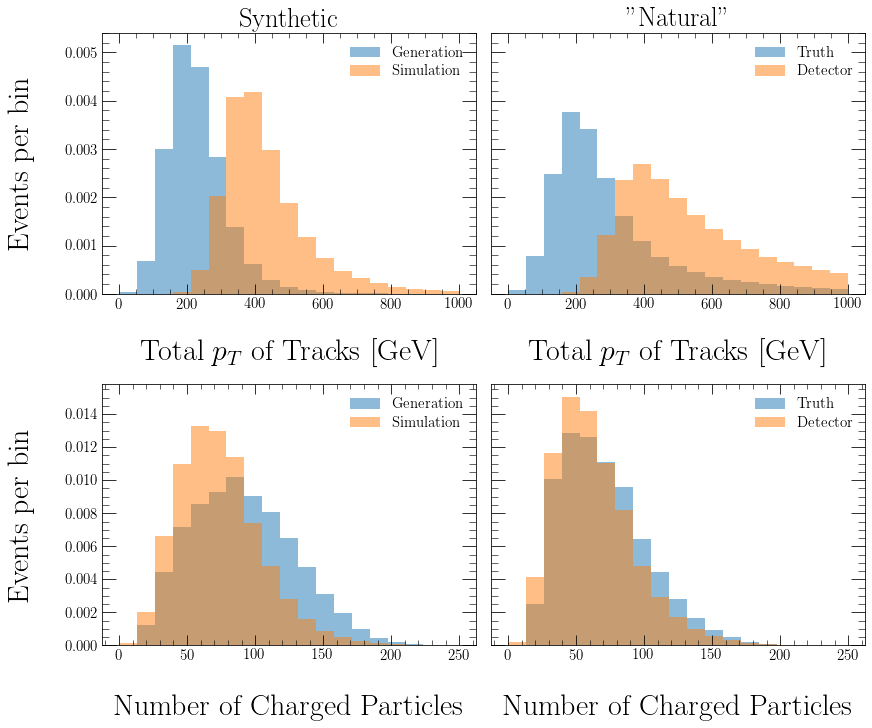

In [40]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(0, 1000, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('Total $p_T$ of Tracks [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('Total $p_T$ of Tracks [GeV]')
hG1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector', 
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation', 
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth', 
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
#                           weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector', 
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define OmniFold Algorithm

In [41]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_0_G: synthetic simulation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level  events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             theta_0_G,
             theta_0_S,
             theta_unknown_S,
             weightsMC_0=None,
             weightsMC_unknown=None):

    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G))

    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] - 0.1
            ) or history.history['val_loss'][0] < 1:
            break
        else:
            del model
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., initial MC for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #         print("Jumpstarting Model\n")
        #         count = 0
        #         while count < 20:
        #             count += 1

        #             model.model.compile(loss='binary_crossentropy',
        #                                 optimizer=keras.optimizers.Adam(),
        #                                 metrics=['accuracy'])
        #             history = model.fit(X_train_1,
        #                                 Y_train_1,
        #                                 sample_weight=w_train_1,
        #                                 epochs=1,
        #                                 batch_size=10000,
        #                                 validation_data=(X_test_1, Y_test_1, w_test_1),
        #                                 verbose=1)
        #             if (history.history['val_loss'][0] < history.history['loss'][0]) or history.history['val_loss'][0]<1:
        #                 break
        #             else:
        #                 reset_weights(model.model)

        #         print("Training Model\n")
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # initial MC for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.model.compile(loss='binary_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold the Full Phase Space

In [42]:
weights, _ = omnifold(iterations=5,
                      theta_0_G=Tracks_0_G,
                      theta_0_S=Tracks_0_S,
#                       weightsMC_0=weightsMC_0[mypass_0],
                      theta_unknown_S=Tracks_unknown_S)#,
#                       weightsMC_unknown=weightsMC_unknown[mypass_unknown])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Jumpstarting Model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1143892 samples, validate on 381298 samples
Epoch 1/1





1143892/1143892 [==============================] - 501s 438us/step - loss: 6.5164 - acc: 0.5907 - val_loss: 6.5025 - val_acc: 0.5921
Train on 1143892 samples, validate on 381298 samples
Epoch 1/1
1143892/1143892 [==============================] - 519s 454us/step - loss: 5.5364 - acc: 0.5719 - val_loss: 0.6807 - val_acc: 0.5917

ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 552s 482us/step - loss: 0.6752 - acc: 0.5914 - val_loss: 0.6694 - val_acc: 0.5922
Epoch 2/200
1143892/1143892 [==============================] - 551s 482us/step - loss: 0.6610 - acc: 0.5985 - val_loss: 0.6400 - val_acc: 0.6385
E

1143892/1143892 [==============================] - 603s 528us/step - loss: 0.5593 - acc: 0.6983 - val_loss: 0.5721 - val_acc: 0.7005
Epoch 6/200
1143892/1143892 [==============================] - 607s 530us/step - loss: 0.5559 - acc: 0.7009 - val_loss: 0.5699 - val_acc: 0.6980
Epoch 7/200
1143892/1143892 [==============================] - 783s 684us/step - loss: 0.5532 - acc: 0.7030 - val_loss: 0.5631 - val_acc: 0.7064
Epoch 8/200
1143892/1143892 [==============================] - 865s 756us/step - loss: 0.5513 - acc: 0.7041 - val_loss: 0.5781 - val_acc: 0.6968
Epoch 9/200
1143892/1143892 [==============================] - 723s 632us/step - loss: 0.5499 - acc: 0.7064 - val_loss: 0.5654 - val_acc: 0.7058
Epoch 10/200
1143892/1143892 [==============================] - 735s 642us/step - loss: 0.5481 - acc: 0.7077 - val_loss: 0.5596 - val_acc: 0.7127
Epoch 11/200
1143892/1143892 [==============================] - 727s 636us/step - loss: 0.5473 - acc: 0.7089 - val_loss: 0.5660 - val_acc: 0.

Epoch 4/200
1143892/1143892 [==============================] - 560s 490us/step - loss: 0.5093 - acc: 0.7100 - val_loss: 0.5180 - val_acc: 0.7280
Epoch 5/200
1143892/1143892 [==============================] - 559s 489us/step - loss: 0.5088 - acc: 0.7091 - val_loss: 0.5115 - val_acc: 0.7205
Epoch 6/200
1143892/1143892 [==============================] - 560s 489us/step - loss: 0.5085 - acc: 0.7094 - val_loss: 0.5167 - val_acc: 0.7264
Epoch 7/200
1143892/1143892 [==============================] - 560s 489us/step - loss: 0.5079 - acc: 0.7095 - val_loss: 0.5095 - val_acc: 0.7238
Epoch 8/200
1143892/1143892 [==============================] - 559s 489us/step - loss: 0.5082 - acc: 0.7106 - val_loss: 0.5140 - val_acc: 0.7279
Epoch 9/200
1143892/1143892 [==============================] - 559s 489us/step - loss: 0.5078 - acc: 0.7101 - val_loss: 0.5135 - val_acc: 0.7271
Epoch 10/200
1143892/1143892 [==============================] - 559s 489us/step - loss: 0.5076 - acc: 0.7102 - val_loss: 0.5077 - 

ITERATION: 1


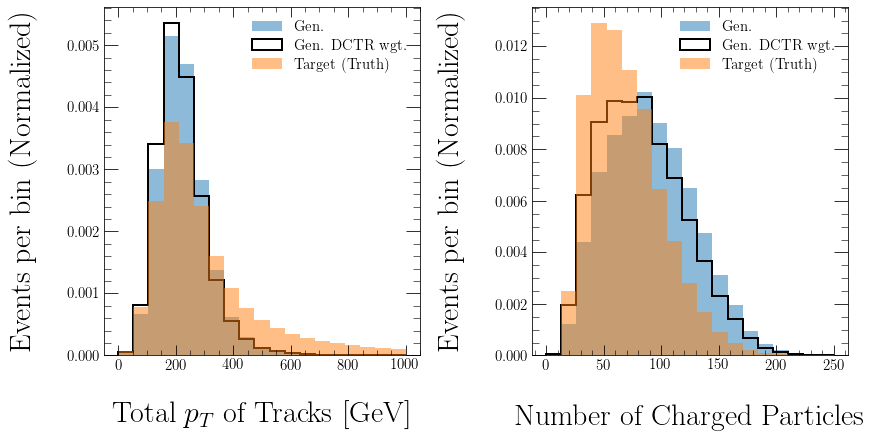

ITERATION: 2


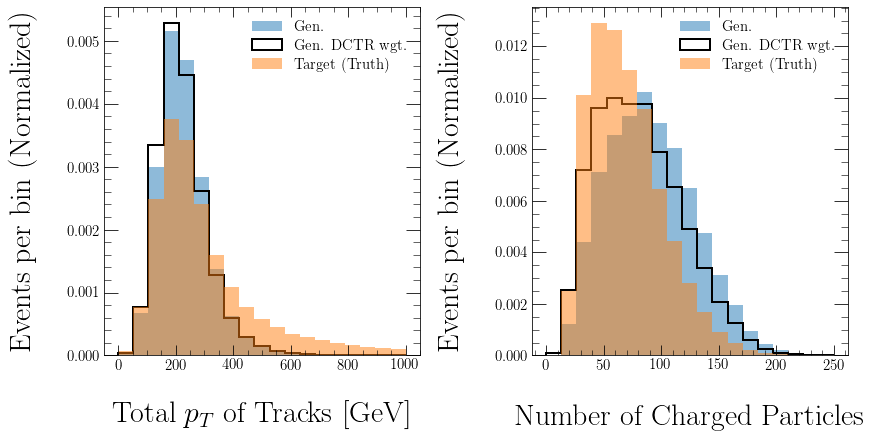

ITERATION: 3


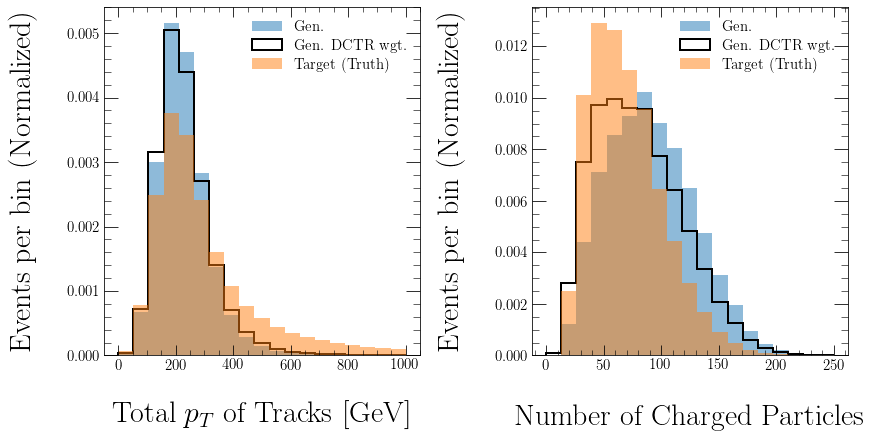

ITERATION: 4


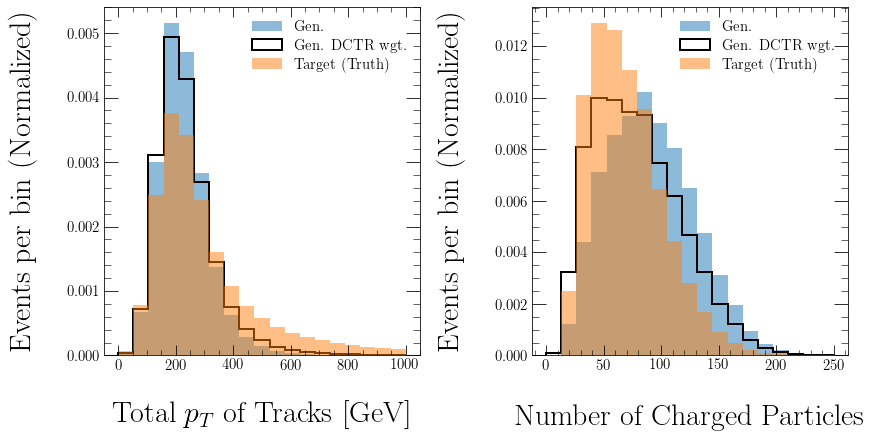

ITERATION: 5


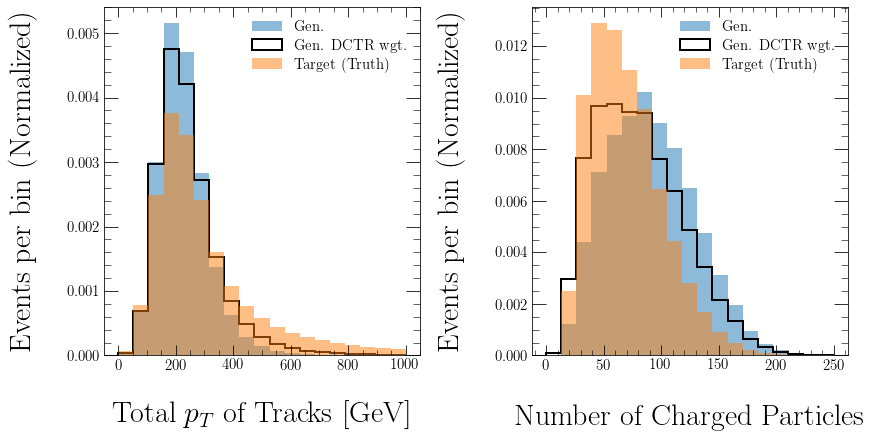

In [43]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_G,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Gen.',
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Gen.',
               **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

ITERATION: 1


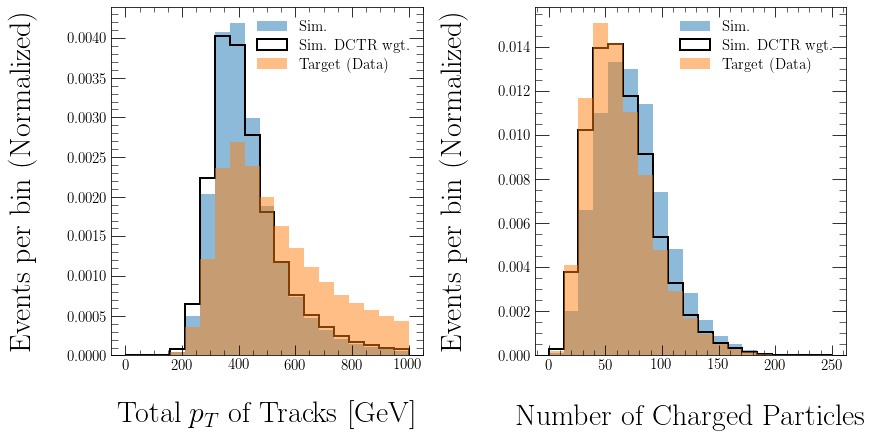

ITERATION: 2


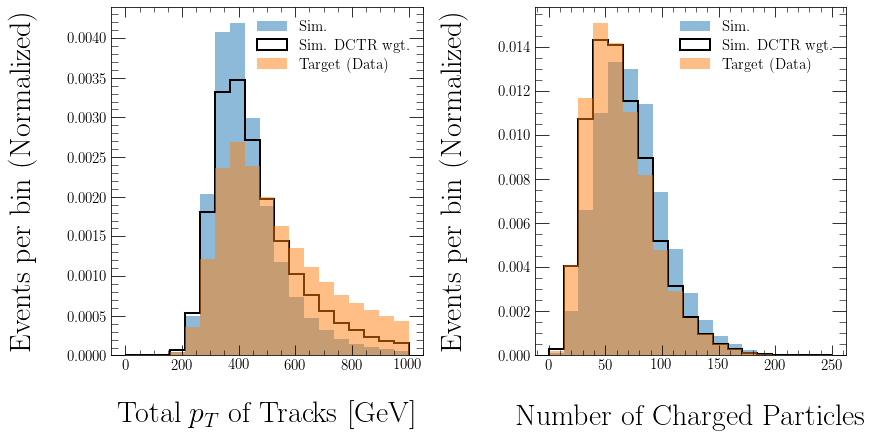

ITERATION: 3


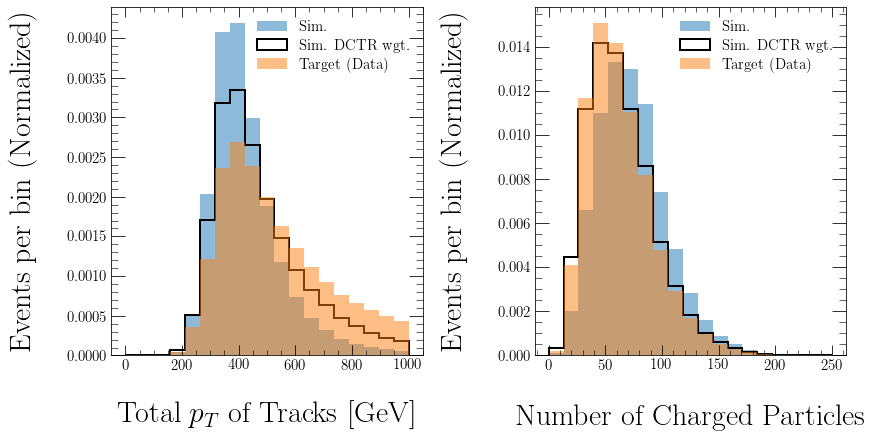

ITERATION: 4


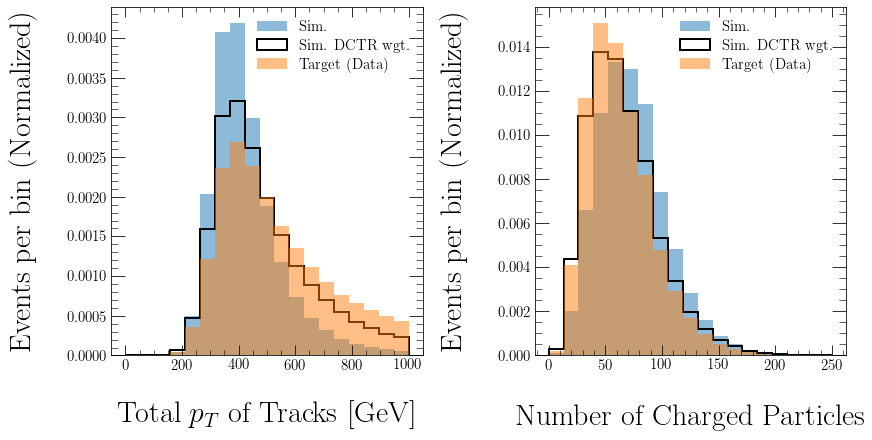

ITERATION: 5


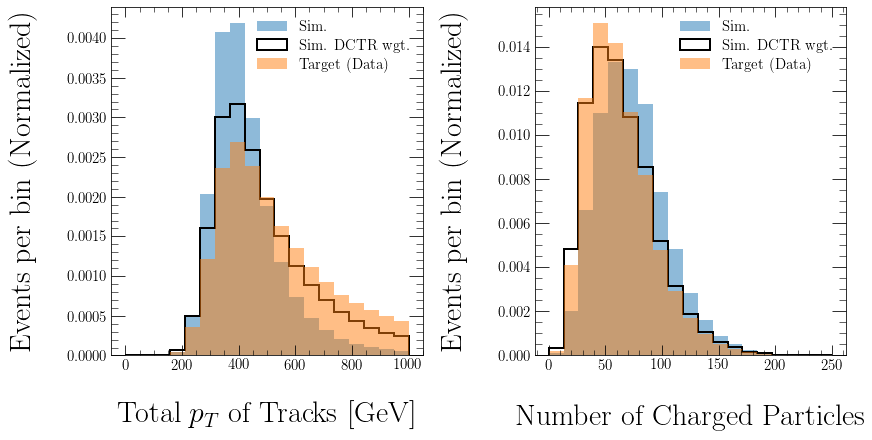

In [45]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_S,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Sim.',
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Sim. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_S,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Data)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
#                weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Sim.',
               **plot_style_2)
    ax[1].hist(nTracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Sim. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_S,
#                weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Data)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()